1. LIBRERÍAS

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.models import EfficientNet_B0_Weights  # Usar EfficientNet-B0
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from numpy import interp

2. CONFIGURACIÓN DEL DISPOSITIVO MPS

In [3]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Dispositivo:", device)

Dispositivo: mps


3. DIRECTORIOS Y TRANSFORMACIONES

In [20]:
data_dir = "./Training_dataset"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")

transform = transforms.Compose([
    transforms.Resize((640, 640)),  # Tamaño recomendado para EfficientNet-B0
    transforms.RandomHorizontalFlip(),  # Data Augmentation
    transforms.RandomRotation(15),     # Data Augmentation
    transforms.ToTensor(),
])

4. CARGA DE DATOS

In [17]:
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = train_dataset.classes

5. CARGAR EfficientNet-B0

In [18]:
efficientnet = models.efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
efficientnet.classifier[1] = nn.Linear(efficientnet.classifier[1].in_features, len(class_names))
efficientnet.classifier[0] = nn.Dropout(p=0.7) 
efficientnet = efficientnet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(efficientnet.parameters(), lr=0.001, weight_decay=1e-4) 
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)
early_stopping_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

 6. ENTRENAMIENTO Y VALIDACIÓN

In [22]:
torch.mps.empty_cache()

In [24]:
train_loss, val_loss, train_acc, val_acc = [], [], [], []
total_time_mps = 0
start_time = time.time()

for epoch in range(100):
    tqdm.write(f"\nEpoch {epoch + 1}/100")
    efficientnet.train()
    running_loss, correct, total = 0.0, 0, 0

    train_loader_tqdm = tqdm(train_loader, desc=f"Entrenando Epoca {epoch + 1}", unit="lote", leave=False)
    for images, labels in train_loader_tqdm:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = efficientnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        train_loader_tqdm.set_postfix({
            'Train Loss': f"{running_loss / (total / labels.size(0)):.4f}",
            'accurate': f"{correct / total:.4f}"
        })

    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_acc = correct / total

    train_loss.append(epoch_train_loss)
    train_acc.append(epoch_train_acc)

    # Validación
    efficientnet.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = efficientnet(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_val_loss = running_loss / len(val_loader)
    epoch_val_acc = correct / total

    val_loss.append(epoch_val_loss)
    val_acc.append(epoch_val_acc)

    early_stopping_scheduler.step(epoch_val_loss)

    tqdm.write(f"Epoca {epoch + 1}/{100} -> "
               f"Train Loss: {epoch_train_loss:.4f}, "
               f"Val Loss: {epoch_val_loss:.4f}, "
               f"accurate: {epoch_train_acc:.4f}, "
               f"val_accurate: {epoch_val_acc:.4f}")

end_time = time.time()
training_time = end_time - start_time 


Epoch 1/100


Epoca 1/100 -> Train Loss: 0.2510, Val Loss: 0.1093, accurate: 0.9251, val_accurate: 0.9662

Epoch 2/100


Epoca 2/100 -> Train Loss: 0.1425, Val Loss: 0.1043, accurate: 0.9570, val_accurate: 0.9696

Epoch 3/100


Epoca 3/100 -> Train Loss: 0.1253, Val Loss: 0.0755, accurate: 0.9622, val_accurate: 0.9800

Epoch 4/100


Epoca 4/100 -> Train Loss: 0.1074, Val Loss: 0.1004, accurate: 0.9667, val_accurate: 0.9702

Epoch 5/100


Epoca 5/100 -> Train Loss: 0.1093, Val Loss: 0.0896, accurate: 0.9683, val_accurate: 0.9731

Epoch 6/100


Epoca 6/100 -> Train Loss: 0.1018, Val Loss: 0.0691, accurate: 0.9694, val_accurate: 0.9807

Epoch 7/100


Epoca 7/100 -> Train Loss: 0.0905, Val Loss: 0.0805, accurate: 0.9730, val_accurate: 0.9751

Epoch 8/100


Epoca 8/100 -> Train Loss: 0.0842, Val Loss: 0.0728, accurate: 0.9749, val_accurate: 0.9758

Epoch 9/100


Epoca 9/100 -> Train Loss: 0.0828, Val Loss: 0.0783, accurate: 0.9740, val_accurate: 0.9758

Epoch 10/100


Epoca 10/100 -> Train Loss: 0.0771, Val Loss: 0.0684, accurate: 0.9768, val_accurate: 0.9780

Epoch 11/100


Epoca 11/100 -> Train Loss: 0.0730, Val Loss: 0.0638, accurate: 0.9774, val_accurate: 0.9798

Epoch 12/100


Epoca 12/100 -> Train Loss: 0.0680, Val Loss: 0.0605, accurate: 0.9796, val_accurate: 0.9833

Epoch 13/100


Epoca 13/100 -> Train Loss: 0.0690, Val Loss: 0.0864, accurate: 0.9783, val_accurate: 0.9742

Epoch 14/100


Epoca 14/100 -> Train Loss: 0.0636, Val Loss: 0.0697, accurate: 0.9809, val_accurate: 0.9820

Epoch 15/100


Epoca 15/100 -> Train Loss: 0.0609, Val Loss: 0.0749, accurate: 0.9804, val_accurate: 0.9773

Epoch 16/100


Epoca 16/100 -> Train Loss: 0.0624, Val Loss: 0.1317, accurate: 0.9813, val_accurate: 0.9691

Epoch 17/100


Epoca 17/100 -> Train Loss: 0.0554, Val Loss: 0.0476, accurate: 0.9838, val_accurate: 0.9882

Epoch 18/100


Epoca 18/100 -> Train Loss: 0.0529, Val Loss: 0.0500, accurate: 0.9832, val_accurate: 0.9851

Epoch 19/100


Epoca 19/100 -> Train Loss: 0.0549, Val Loss: 0.0483, accurate: 0.9835, val_accurate: 0.9860

Epoch 20/100


Epoca 20/100 -> Train Loss: 0.0520, Val Loss: 0.0556, accurate: 0.9837, val_accurate: 0.9849

Epoch 21/100


Epoca 21/100 -> Train Loss: 0.0503, Val Loss: 0.0482, accurate: 0.9840, val_accurate: 0.9858

Epoch 22/100


Epoca 22/100 -> Train Loss: 0.0471, Val Loss: 0.0695, accurate: 0.9860, val_accurate: 0.9782

Epoch 23/100


Epoca 23/100 -> Train Loss: 0.0474, Val Loss: 0.0444, accurate: 0.9853, val_accurate: 0.9882

Epoch 24/100


Epoca 24/100 -> Train Loss: 0.0516, Val Loss: 0.0525, accurate: 0.9843, val_accurate: 0.9869

Epoch 25/100


Epoca 25/100 -> Train Loss: 0.0505, Val Loss: 0.0497, accurate: 0.9838, val_accurate: 0.9851

Epoch 26/100


Epoca 26/100 -> Train Loss: 0.0471, Val Loss: 0.0421, accurate: 0.9865, val_accurate: 0.9882

Epoch 27/100


Epoca 27/100 -> Train Loss: 0.0526, Val Loss: 0.0375, accurate: 0.9843, val_accurate: 0.9893

Epoch 28/100


Epoca 28/100 -> Train Loss: 0.0433, Val Loss: 0.0416, accurate: 0.9862, val_accurate: 0.9884

Epoch 29/100


Epoca 29/100 -> Train Loss: 0.0391, Val Loss: 0.0421, accurate: 0.9882, val_accurate: 0.9893

Epoch 30/100


Epoca 30/100 -> Train Loss: 0.0435, Val Loss: 0.0497, accurate: 0.9863, val_accurate: 0.9867

Epoch 31/100


Epoca 31/100 -> Train Loss: 0.0458, Val Loss: 0.0372, accurate: 0.9857, val_accurate: 0.9882

Epoch 32/100


Epoca 32/100 -> Train Loss: 0.0411, Val Loss: 0.0410, accurate: 0.9869, val_accurate: 0.9887

Epoch 33/100


Epoca 33/100 -> Train Loss: 0.0390, Val Loss: 0.0504, accurate: 0.9876, val_accurate: 0.9873

Epoch 34/100


Epoca 34/100 -> Train Loss: 0.0362, Val Loss: 0.0482, accurate: 0.9890, val_accurate: 0.9896

Epoch 35/100


Epoca 35/100 -> Train Loss: 0.0415, Val Loss: 0.0429, accurate: 0.9866, val_accurate: 0.9880

Epoch 36/100


Epoca 36/100 -> Train Loss: 0.0376, Val Loss: 0.0329, accurate: 0.9881, val_accurate: 0.9902

Epoch 37/100


Epoca 37/100 -> Train Loss: 0.0384, Val Loss: 0.0479, accurate: 0.9874, val_accurate: 0.9869

Epoch 38/100


Epoca 38/100 -> Train Loss: 0.0359, Val Loss: 0.0482, accurate: 0.9889, val_accurate: 0.9864

Epoch 39/100


Epoca 39/100 -> Train Loss: 0.0377, Val Loss: 0.0617, accurate: 0.9886, val_accurate: 0.9809

Epoch 40/100


Epoca 40/100 -> Train Loss: 0.0365, Val Loss: 0.0483, accurate: 0.9887, val_accurate: 0.9880

Epoch 41/100


Epoca 41/100 -> Train Loss: 0.0424, Val Loss: 0.0430, accurate: 0.9867, val_accurate: 0.9876

Epoch 42/100


Epoca 42/100 -> Train Loss: 0.0408, Val Loss: 0.0471, accurate: 0.9883, val_accurate: 0.9869

Epoch 43/100


Epoca 43/100 -> Train Loss: 0.0307, Val Loss: 0.0591, accurate: 0.9906, val_accurate: 0.9833

Epoch 44/100


Epoca 44/100 -> Train Loss: 0.0369, Val Loss: 0.0420, accurate: 0.9885, val_accurate: 0.9898

Epoch 45/100


Epoca 45/100 -> Train Loss: 0.0405, Val Loss: 0.0405, accurate: 0.9881, val_accurate: 0.9898

Epoch 46/100


Epoca 46/100 -> Train Loss: 0.0293, Val Loss: 0.0499, accurate: 0.9913, val_accurate: 0.9853

Epoch 47/100


Epoca 47/100 -> Train Loss: 0.0343, Val Loss: 0.0430, accurate: 0.9901, val_accurate: 0.9878

Epoch 48/100


Epoca 48/100 -> Train Loss: 0.0180, Val Loss: 0.0288, accurate: 0.9940, val_accurate: 0.9933

Epoch 49/100


Epoca 49/100 -> Train Loss: 0.0167, Val Loss: 0.0321, accurate: 0.9954, val_accurate: 0.9909

Epoch 50/100


Epoca 50/100 -> Train Loss: 0.0173, Val Loss: 0.0355, accurate: 0.9953, val_accurate: 0.9918

Epoch 51/100


Epoca 51/100 -> Train Loss: 0.0137, Val Loss: 0.0330, accurate: 0.9961, val_accurate: 0.9909

Epoch 52/100


Epoca 52/100 -> Train Loss: 0.0140, Val Loss: 0.0358, accurate: 0.9963, val_accurate: 0.9900

Epoch 53/100


Epoca 53/100 -> Train Loss: 0.0148, Val Loss: 0.0293, accurate: 0.9956, val_accurate: 0.9944

Epoch 54/100


Epoca 54/100 -> Train Loss: 0.0157, Val Loss: 0.0330, accurate: 0.9950, val_accurate: 0.9907

Epoch 55/100


Epoca 55/100 -> Train Loss: 0.0125, Val Loss: 0.0396, accurate: 0.9960, val_accurate: 0.9887

Epoch 56/100


Epoca 56/100 -> Train Loss: 0.0158, Val Loss: 0.0313, accurate: 0.9954, val_accurate: 0.9933

Epoch 57/100


Epoca 57/100 -> Train Loss: 0.0161, Val Loss: 0.0239, accurate: 0.9947, val_accurate: 0.9942

Epoch 58/100


Epoca 58/100 -> Train Loss: 0.0113, Val Loss: 0.0316, accurate: 0.9971, val_accurate: 0.9920

Epoch 59/100


Epoca 59/100 -> Train Loss: 0.0145, Val Loss: 0.0315, accurate: 0.9959, val_accurate: 0.9929

Epoch 60/100


Epoca 60/100 -> Train Loss: 0.0144, Val Loss: 0.0381, accurate: 0.9959, val_accurate: 0.9909

Epoch 61/100


Epoca 61/100 -> Train Loss: 0.0182, Val Loss: 0.0296, accurate: 0.9947, val_accurate: 0.9931

Epoch 62/100


Epoca 62/100 -> Train Loss: 0.0152, Val Loss: 0.0234, accurate: 0.9947, val_accurate: 0.9944

Epoch 63/100


Epoca 63/100 -> Train Loss: 0.0142, Val Loss: 0.0278, accurate: 0.9959, val_accurate: 0.9938

Epoch 64/100


Epoca 64/100 -> Train Loss: 0.0151, Val Loss: 0.0276, accurate: 0.9954, val_accurate: 0.9944

Epoch 65/100


Epoca 65/100 -> Train Loss: 0.0128, Val Loss: 0.0306, accurate: 0.9959, val_accurate: 0.9913

Epoch 66/100


Epoca 66/100 -> Train Loss: 0.0136, Val Loss: 0.0287, accurate: 0.9967, val_accurate: 0.9924

Epoch 67/100


Epoca 67/100 -> Train Loss: 0.0159, Val Loss: 0.0340, accurate: 0.9952, val_accurate: 0.9920

Epoch 68/100


Epoca 68/100 -> Train Loss: 0.0153, Val Loss: 0.0326, accurate: 0.9953, val_accurate: 0.9911

Epoch 69/100


Epoca 69/100 -> Train Loss: 0.0107, Val Loss: 0.0308, accurate: 0.9973, val_accurate: 0.9924

Epoch 70/100


Epoca 70/100 -> Train Loss: 0.0166, Val Loss: 0.0369, accurate: 0.9952, val_accurate: 0.9913

Epoch 71/100


Epoca 71/100 -> Train Loss: 0.0129, Val Loss: 0.0219, accurate: 0.9962, val_accurate: 0.9940

Epoch 72/100


Epoca 72/100 -> Train Loss: 0.0183, Val Loss: 0.0293, accurate: 0.9937, val_accurate: 0.9922

Epoch 73/100


Epoca 73/100 -> Train Loss: 0.0138, Val Loss: 0.0321, accurate: 0.9965, val_accurate: 0.9909

Epoch 74/100


Epoca 74/100 -> Train Loss: 0.0138, Val Loss: 0.0294, accurate: 0.9967, val_accurate: 0.9916

Epoch 75/100


Epoca 75/100 -> Train Loss: 0.0158, Val Loss: 0.0294, accurate: 0.9951, val_accurate: 0.9938

Epoch 76/100


Epoca 76/100 -> Train Loss: 0.0133, Val Loss: 0.0278, accurate: 0.9960, val_accurate: 0.9916

Epoch 77/100


Epoca 77/100 -> Train Loss: 0.0139, Val Loss: 0.0377, accurate: 0.9961, val_accurate: 0.9911

Epoch 78/100


Epoca 78/100 -> Train Loss: 0.0172, Val Loss: 0.0315, accurate: 0.9943, val_accurate: 0.9922

Epoch 79/100


Epoca 79/100 -> Train Loss: 0.0142, Val Loss: 0.0294, accurate: 0.9955, val_accurate: 0.9916

Epoch 80/100


Epoca 80/100 -> Train Loss: 0.0147, Val Loss: 0.0282, accurate: 0.9958, val_accurate: 0.9927

Epoch 81/100


Epoca 81/100 -> Train Loss: 0.0158, Val Loss: 0.0362, accurate: 0.9953, val_accurate: 0.9911

Epoch 82/100


Epoca 82/100 -> Train Loss: 0.0146, Val Loss: 0.0402, accurate: 0.9953, val_accurate: 0.9907

Epoch 83/100


Epoca 83/100 -> Train Loss: 0.0080, Val Loss: 0.0285, accurate: 0.9977, val_accurate: 0.9938

Epoch 84/100


Epoca 84/100 -> Train Loss: 0.0056, Val Loss: 0.0274, accurate: 0.9986, val_accurate: 0.9942

Epoch 85/100


Epoca 85/100 -> Train Loss: 0.0072, Val Loss: 0.0280, accurate: 0.9981, val_accurate: 0.9936

Epoch 86/100


Epoca 86/100 -> Train Loss: 0.0060, Val Loss: 0.0351, accurate: 0.9985, val_accurate: 0.9918

Epoch 87/100


Epoca 87/100 -> Train Loss: 0.0069, Val Loss: 0.0279, accurate: 0.9981, val_accurate: 0.9933

Epoch 88/100


Epoca 88/100 -> Train Loss: 0.0078, Val Loss: 0.0252, accurate: 0.9979, val_accurate: 0.9936

Epoch 89/100


Epoca 89/100 -> Train Loss: 0.0046, Val Loss: 0.0314, accurate: 0.9991, val_accurate: 0.9924

Epoch 90/100


Epoca 90/100 -> Train Loss: 0.0057, Val Loss: 0.0343, accurate: 0.9984, val_accurate: 0.9929

Epoch 91/100


Epoca 91/100 -> Train Loss: 0.0079, Val Loss: 0.0330, accurate: 0.9978, val_accurate: 0.9922

Epoch 92/100


Epoca 92/100 -> Train Loss: 0.0067, Val Loss: 0.0273, accurate: 0.9981, val_accurate: 0.9929

Epoch 93/100


Epoca 93/100 -> Train Loss: 0.0057, Val Loss: 0.0284, accurate: 0.9984, val_accurate: 0.9933

Epoch 94/100


Epoca 94/100 -> Train Loss: 0.0037, Val Loss: 0.0269, accurate: 0.9990, val_accurate: 0.9944

Epoch 95/100


Epoca 95/100 -> Train Loss: 0.0032, Val Loss: 0.0283, accurate: 0.9994, val_accurate: 0.9938

Epoch 96/100


Epoca 96/100 -> Train Loss: 0.0031, Val Loss: 0.0302, accurate: 0.9993, val_accurate: 0.9927

Epoch 97/100


Epoca 97/100 -> Train Loss: 0.0031, Val Loss: 0.0250, accurate: 0.9993, val_accurate: 0.9942

Epoch 98/100


Epoca 98/100 -> Train Loss: 0.0035, Val Loss: 0.0288, accurate: 0.9992, val_accurate: 0.9929

Epoch 99/100


Epoca 99/100 -> Train Loss: 0.0036, Val Loss: 0.0271, accurate: 0.9992, val_accurate: 0.9936

Epoch 100/100


Epoca 100/100 -> Train Loss: 0.0037, Val Loss: 0.0267, accurate: 0.9992, val_accurate: 0.9938


7. GUARDAR EL MODELO

In [25]:
torch.save(efficientnet.state_dict(), "Models/EfficientNet_B0_model.pth")

8. EVALUACIÓN EN EL CONJUNTO DE PRUEBA

In [26]:
os.makedirs("EfficientNet_B0", exist_ok=True)
efficientnet.eval()
y_true, y_pred = [], []
embeddings = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        # Extraer embedding
        features = efficientnet.features(images)
        embeddings.append(features.view(features.size(0), -1).cpu().numpy())
        outputs = efficientnet(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

embeddings = np.concatenate(embeddings)
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df.to_excel("EfficientNet_B0/Metricas_EfficientNetBO.xlsx")

9. MATRIZ DE CONFUSIÓN

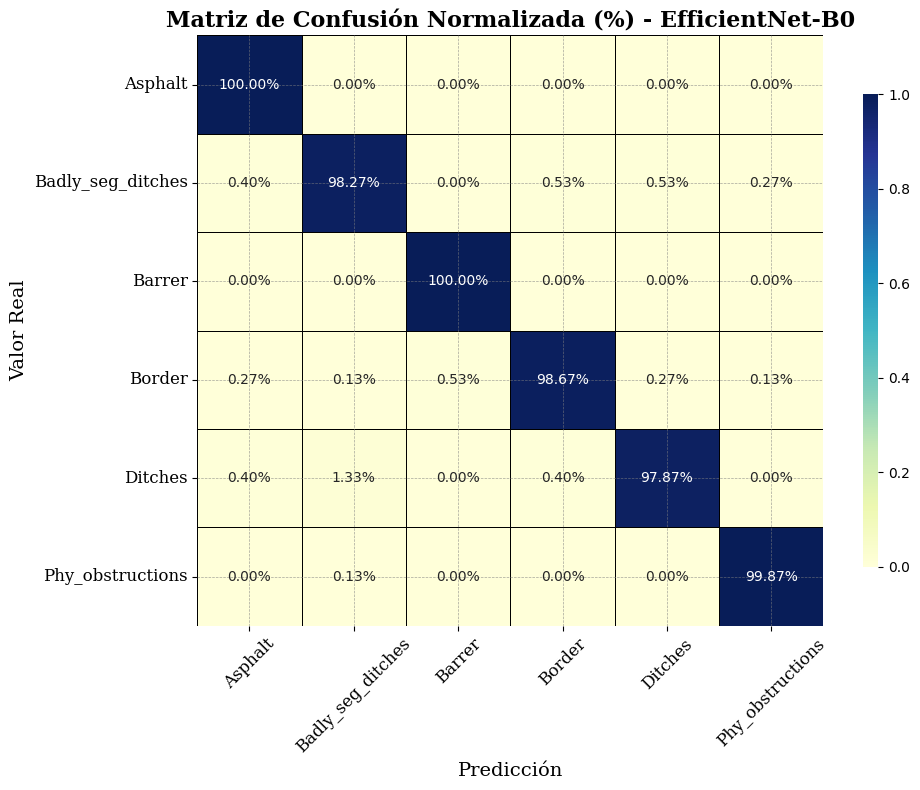

Matriz de confusión guardada en 'EfficientNet_B0'.


In [27]:
conf_matrix = confusion_matrix(y_true, y_pred)
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

os.makedirs("EfficientNet_B0", exist_ok=True)

plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix_norm, 
    annot=True, 
    fmt='.2%', 
    cmap='YlGnBu',         # Cambiado a 'YlGnBu' para un estilo más claro y elegante
    xticklabels=class_names, 
    yticklabels=class_names,
    linewidths=0.5,         # Líneas finas para separar celdas
    linecolor='black',      # Líneas en negro para mayor contraste
    cbar_kws={'aspect': 30, 'shrink': 0.8}  # Barra de color ajustada
)

plt.title('Matriz de Confusión Normalizada (%) - EfficientNet-B0', fontsize=16, fontweight='bold', family='serif')
plt.xlabel('Predicción', fontsize=14, family='serif')
plt.ylabel('Valor Real', fontsize=14, family='serif')
plt.xticks(rotation=45, fontsize=12, family='serif')
plt.yticks(rotation=0, fontsize=12, family='serif')
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()

plt.savefig("EfficientNet_B0/Matriz_confusion.svg", format='svg', dpi=300, bbox_inches='tight')
plt.savefig("EfficientNet_B0/Matriz_confusion.png", dpi=300, bbox_inches='tight')
plt.show()

print("Matriz de confusión guardada en 'EfficientNet_B0'.")


10. GRAFICAR MÉTRICAS

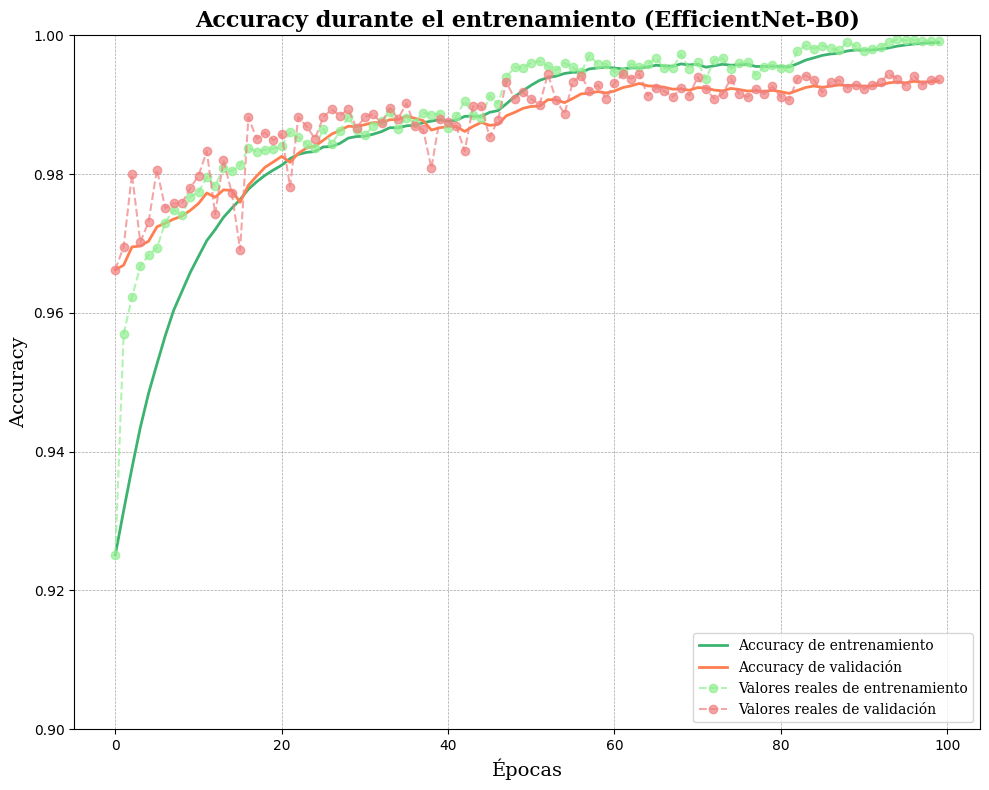

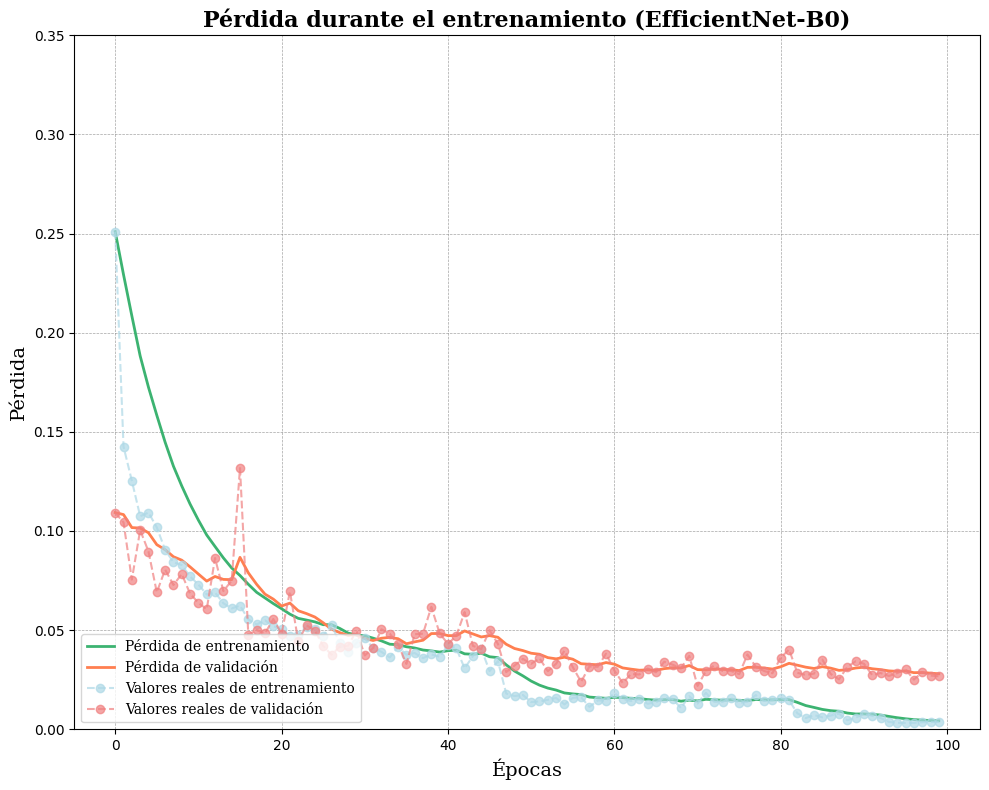

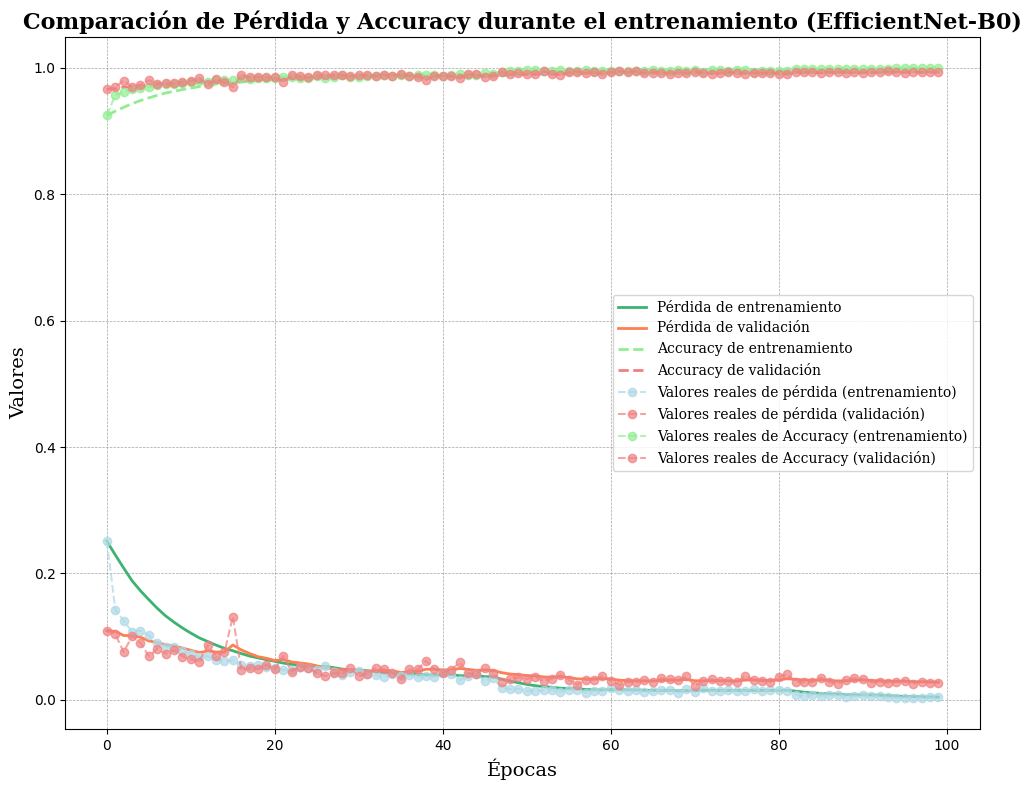

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import os

def suavizar(valores, peso=0.8):
    smoothed = []
    ultimo = valores[0]
    for punto in valores:
        smoothed_val = ultimo * peso + (1 - peso) * punto
        smoothed.append(smoothed_val)
        ultimo = smoothed_val
    return smoothed

train_acc_smooth = suavizar(train_acc)
val_acc_smooth = suavizar(val_acc)
train_loss_smooth = suavizar(train_loss)
val_loss_smooth = suavizar(val_loss)

os.makedirs("EfficientNet_B0", exist_ok=True)

# Gráfica 1: Accuracy durante el entrenamiento
plt.figure(figsize=(10, 8))
plt.plot(train_acc_smooth, label='Accuracy de entrenamiento', linestyle='-', linewidth=2, color='mediumseagreen')
plt.plot(val_acc_smooth, label='Accuracy de validación', linestyle='-', linewidth=2, color='coral')
plt.plot(train_acc, 'o--', alpha=0.7, color='lightgreen', label='Valores reales de entrenamiento')
plt.plot(val_acc, 'o--', alpha=0.7, color='lightcoral', label='Valores reales de validación')
plt.xlabel('Épocas', fontsize=14, family='serif')
plt.ylabel('Accuracy', fontsize=14, family='serif')
plt.title('Accuracy durante el entrenamiento (EfficientNet-B0)', fontsize=16, fontweight='bold', family='serif')
plt.ylim([0.9, 1.0])
plt.legend(loc='lower right', fontsize=12, prop={'family': 'serif'})
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.savefig("EfficientNet_B0/Accuracy_EfficientNet_B0.svg", format='svg', dpi=300, bbox_inches='tight')
plt.savefig("EfficientNet_B0/Accuracy_EfficientNet_B0.png", dpi=300, bbox_inches='tight')
plt.show()

# Gráfica 2: Pérdida durante el entrenamiento
plt.figure(figsize=(10, 8))
plt.plot(train_loss_smooth, label='Pérdida de entrenamiento', linestyle='-', linewidth=2, color='mediumseagreen')
plt.plot(val_loss_smooth, label='Pérdida de validación', linestyle='-', linewidth=2, color='coral')
plt.plot(train_loss, 'o--', alpha=0.7, color='lightblue', label='Valores reales de entrenamiento')
plt.plot(val_loss, 'o--', alpha=0.7, color='lightcoral', label='Valores reales de validación')
plt.xlabel('Épocas', fontsize=14, family='serif')
plt.ylabel('Pérdida', fontsize=14, family='serif')
plt.title('Pérdida durante el entrenamiento (EfficientNet-B0)', fontsize=16, fontweight='bold', family='serif')
plt.ylim([0, 0.35])
plt.legend(loc='lower left', fontsize=12, prop={'family': 'serif'})
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.savefig("EfficientNet_B0/Perdida_EfficientNet_B0.svg", format='svg', dpi=300, bbox_inches='tight')
plt.savefig("EfficientNet_B0/Perdida_EfficientNet_B0.png", dpi=300, bbox_inches='tight')
plt.show()

# Gráfica 3: Comparación de Pérdida y Accuracy durante el entrenamiento
plt.figure(figsize=(10, 8))
plt.plot(train_loss_smooth, label='Pérdida de entrenamiento', linestyle='-', linewidth=2, color='mediumseagreen')
plt.plot(val_loss_smooth, label='Pérdida de validación', linestyle='-', linewidth=2, color='coral')
plt.plot(train_acc_smooth, label='Accuracy de entrenamiento', linestyle='--', linewidth=2, color='lightgreen')
plt.plot(val_acc_smooth, label='Accuracy de validación ', linestyle='--', linewidth=2, color='lightcoral')
plt.plot(train_loss, 'o--', alpha=0.7, color='lightblue', label='Valores reales de pérdida (entrenamiento)')
plt.plot(val_loss, 'o--', alpha=0.7, color='lightcoral', label='Valores reales de pérdida (validación)')
plt.plot(train_acc, 'o--', alpha=0.7, color='lightgreen', label='Valores reales de Accuracy (entrenamiento)')
plt.plot(val_acc, 'o--', alpha=0.7, color='lightcoral', label='Valores reales de Accuracy (validación)')
plt.xlabel('Épocas', fontsize=14, family='serif')
plt.ylabel('Valores', fontsize=14, family='serif')
plt.title('Comparación de Pérdida y Accuracy durante el entrenamiento (EfficientNet-B0)', fontsize=16, fontweight='bold', family='serif')
plt.legend(loc='best', fontsize=12, prop={'family': 'serif'})
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.savefig("EfficientNet_B0/Comparacion_Perdida_Accuracy_EfficientNet_B0.svg", format='svg', dpi=300, bbox_inches='tight')
plt.savefig("EfficientNet_B0/Comparacion_Perdida_Accuracy_EfficientNet_B0.png", dpi=300, bbox_inches='tight')
plt.show()


11. ANÁLISIS DE VECTORES (Vector Analysis)

Generando análisis de vectores...
Tamaño de f1_scores: 4500
Forma de embeddings antes de reshape: (4500, 62720)
Forma de embeddings después de reshape: (4500, 62720)


/Users/ivanbermudez/Downloads/Entrenamiento_CNN_Clasificadora/.venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Tamaño de embeddings_2d: (4500, 2)
Tamaño de f1_scores: 4500


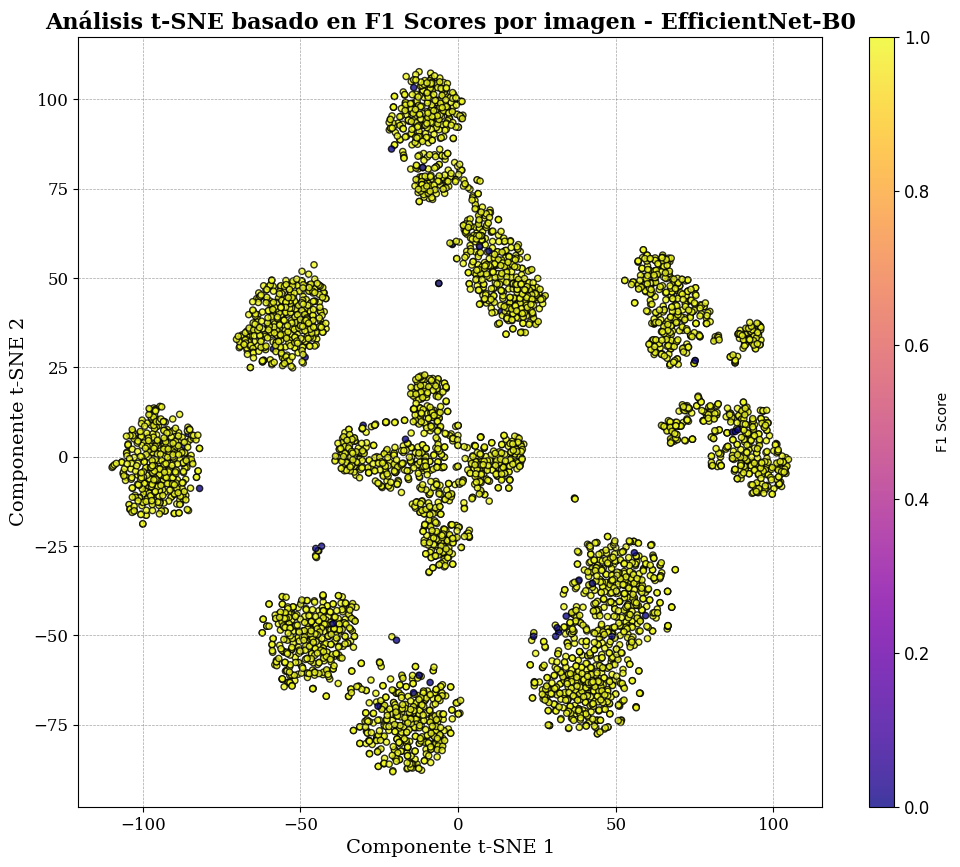

Análisis de vectores completado. Resultados guardados en 'EfficientNet_B0'.


In [29]:
print("Generando análisis de vectores...")

efficientnet.eval()
y_true, y_pred, embeddings = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = efficientnet(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

        # Extraer y almacenar embeddings
        features = efficientnet.features(images)
        embeddings.append(features.view(features.size(0), -1).cpu().numpy())

# Unificar embeddings en una matriz NumPy
embeddings = np.concatenate(embeddings)

# Calcular F1 Scores por imagen
f1_scores = [f1_score([true], [pred], average='weighted') for true, pred in zip(y_true, y_pred)]
print("Tamaño de f1_scores:", len(f1_scores))

# Verificar y ajustar la forma de embeddings
print("Forma de embeddings antes de reshape:", embeddings.shape)
if len(embeddings.shape) == 1:
    embeddings = embeddings.reshape(-1, 1)
print("Forma de embeddings después de reshape:", embeddings.shape)

# Aplicar t-SNE con parámetros ajustados
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=3000)
embeddings_2d = tsne.fit_transform(embeddings)

print("Tamaño de embeddings_2d:", embeddings_2d.shape)
print("Tamaño de f1_scores:", len(f1_scores))

# Generar el gráfico t-SNE con la paleta 'plasma'
plt.figure(figsize=(12, 10))
scatter = plt.scatter(
    x=embeddings_2d[:, 0], 
    y=embeddings_2d[:, 1], 
    c=f1_scores, 
    cmap='plasma',  # Cambiar a 'plasma' para un estilo más llamativo
    s=20,            # Tamaño de los puntos ajustado para profesionalismo
    alpha=0.8,       # Transparencia para evitar solapamientos
    edgecolor='k'    # Bordes negros para mayor contraste
)
cbar = plt.colorbar(scatter, label='F1 Score', aspect=30)
cbar.ax.tick_params(labelsize=12)

# Personalización avanzada del gráfico
plt.title('Análisis t-SNE basado en F1 Scores por imagen - EfficientNet-B0', fontsize=16, fontweight='bold', family='serif')
plt.xlabel('Componente t-SNE 1', fontsize=14, family='serif')
plt.ylabel('Componente t-SNE 2', fontsize=14, family='serif')
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.xticks(fontsize=12, family='serif')
plt.yticks(fontsize=12, family='serif')

# Guardar el gráfico en formato SVG para alta calidad en presentaciones
plt.savefig("EfficientNet_B0/Vector_Analysis_EfficientNet_B0_Plasma.svg", format='svg', dpi=300, bbox_inches='tight')
plt.savefig("EfficientNet_B0/Vector_Analysis_EfficientNet_B0_Plasma.png", dpi=300, bbox_inches='tight')
plt.show()

# Guardar los datos procesados
df_embeddings = pd.DataFrame(embeddings_2d, columns=['Componente_1', 'Componente_2'])
df_embeddings['F1_Score'] = f1_scores
df_embeddings.to_csv("EfficientNet_B0/Embeddings_y_F1Scores_Plasma.csv", index=False)

print("Análisis de vectores completado. Resultados guardados en 'EfficientNet_B0'.")


12. EVALUACIÓN EN EL CONJUNTO DE PRUEBA

Generando predicciones y calculando scores...


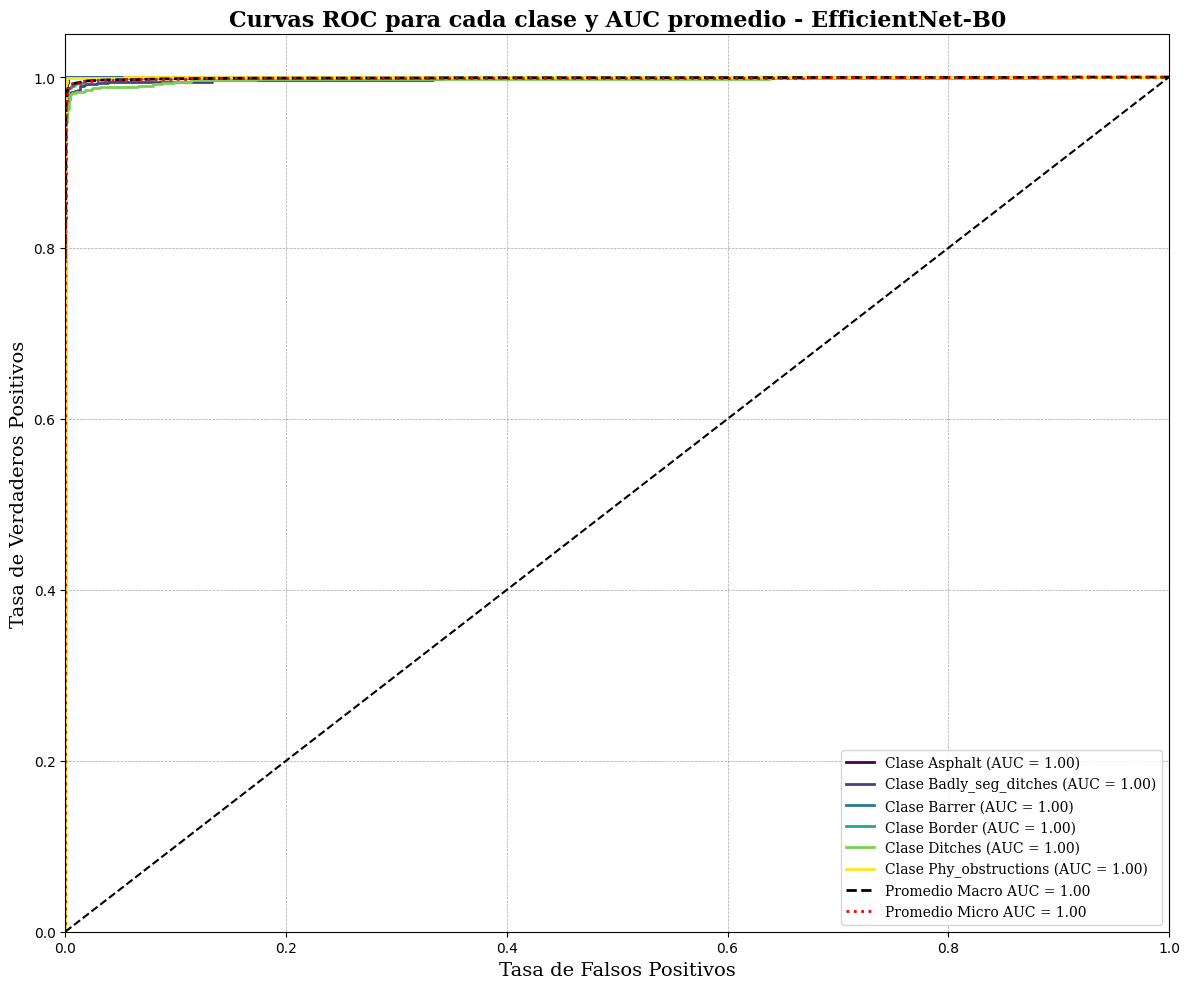

Curvas ROC generadas y guardadas en 'EfficientNet_B0'.


In [30]:
print("Generando predicciones y calculando scores...")
efficientnet.eval()
y_true, y_pred, y_scores = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = efficientnet(images)
        y_scores.extend(outputs.cpu().numpy())
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

y_scores = np.array(y_scores)
y_true_bin = label_binarize(y_true, classes=list(range(len(class_names))))

fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(class_names))]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(class_names)):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= len(class_names)
macro_auc = auc(all_fpr, mean_tpr)

fpr_micro, tpr_micro, _ = roc_curve(y_true_bin.ravel(), y_scores.ravel())
micro_auc = auc(fpr_micro, tpr_micro)

os.makedirs("EfficientNet_B0", exist_ok=True)

plt.figure(figsize=(12, 10))
colors = plt.cm.viridis(np.linspace(0, 1, len(class_names)))

for i, color in zip(range(len(class_names)), colors):
    plt.plot(fpr[i], tpr[i], color=color, linewidth=2,
             label=f'Clase {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot(all_fpr, mean_tpr, linestyle='--', color='black', linewidth=2,
         label=f'Promedio Macro AUC = {macro_auc:.2f}')
plt.plot(fpr_micro, tpr_micro, linestyle=':', color='red', linewidth=2,
         label=f'Promedio Micro AUC = {micro_auc:.2f}')

plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos', fontsize=14, family='serif')
plt.ylabel('Tasa de Verdaderos Positivos', fontsize=14, family='serif')
plt.title('Curvas ROC para cada clase y AUC promedio - EfficientNet-B0', fontsize=16, fontweight='bold', family='serif')
plt.legend(loc='lower right', fontsize=12, prop={'family': 'serif'}, frameon=True, fancybox=True, framealpha=0.8)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.savefig("EfficientNet_B0/Curva_ROC_AUC.svg", format='svg', dpi=300, bbox_inches='tight')
plt.savefig("EfficientNet_B0/Curva_ROC_AUC.png", dpi=300, bbox_inches='tight')
plt.show()

clases = class_names + ['Promedio Macro', 'Promedio Micro']
auc_scores = [roc_auc[i] for i in range(len(class_names))] + [macro_auc, micro_auc]
tipo = ['Individual'] * len(class_names) + ['Promedio Macro', 'Promedio Micro']

assert len(clases) == len(auc_scores) == len(tipo), "Las listas no tienen la misma longitud"

roc_data = {
    'Clase': clases,
    'AUC': auc_scores,
    'Tipo': tipo
}
df_roc = pd.DataFrame(roc_data)
df_roc.to_csv("EfficientNet_B0/Curvas_ROC_AUC_Resumen.csv", index=False)

print("Curvas ROC generadas y guardadas en 'EfficientNet_B0'.")


13. GUARDAR INFORME

In [31]:
with open("EfficientNet_B0/Detalles_entrenamiento_EfficientNet_B0.txt", "w") as f:
    f.write(f"Tiempo total de entrenamiento: {training_time:.2f} segundos\n")
    f.write(f"Dispositivo: {device}\n")
    f.write("Modelo: EfficientNet-B0\n")
    f.write("Directorio del modelo: Models/EfficientNet_B0_model.pth\n")
    f.write(f"Parámetros: {sum(p.numel() for p in efficientnet.parameters())}\n")
    f.write("Métricas:\n")
    f.write(report_df.to_string())
    f.write("\n\nMatriz de Confusión guardada en: EfficientNet_B0/Matriz_confusion_EfficientNet_B0.png\n")
    f.write("Análisis de Vectores guardado en: EfficientNet_B0/Vector_Analysis_EfficientNet_B0.png\n")

print("Entrenamiento y evaluación completados. Resultados guardados en 'EfficientNet_B0'.")

Entrenamiento y evaluación completados. Resultados guardados en 'EfficientNet_B0'.
